# **Occlusion Detection of Object with using Faster-rcnn**

---

---

## **Table of contents**

* [Import utilities](#Import-utilities)

* [Extract info. from xml files](#Extract-info.-from-xml-files)

* [Make dataframe from extracted information](#Make-dataframe-from-extracted-information)

* [Separate train and validation data](#Separate-train-and-validation-data)

* [View sample](#View-sample)

* [Download pretrained model](#Download-pretrained-model)

* [Train object detection model](#Train-object-detection-model)

* [Test model](#Test-model)

In [45]:
# run this before running the code
# if you still package not installed error for any of the packages, find the pip install for that package 

pip install opencv-python-headless
pip install -U albumentations
pip install torch
pip install torchvision



SyntaxError: invalid syntax (1770391119.py, line 4)

## **Import utilities**

In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing 


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [2]:
BASE_PATH = '/Users/oomprakash/Desktop/python'
XML_PATH = os.path.join(BASE_PATH, "TrainAnnotations")
IMG_PATH = os.path.join(BASE_PATH, "TrainImages")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]


In [3]:
XML_PATH

'/Users/oomprakash/Desktop/python/TrainAnnotations'

In [4]:
IMG_PATH

'/Users/oomprakash/Desktop/python/TrainImages'

## **Extract info. from xml files**

In [5]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

## **Make dataframe from extracted information**

In [6]:
def xml_files_to_df(xml_files):
    
    """"Return pandas dataframe from list of XML files."""
    
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

df = xml_files_to_df(XML_FILES)
df.head()

image_id   names                 boxes  \
0  apple_49.jpg   apple    [15, 87, 255, 291]   
1  apple_75.jpg   apple     [5, 31, 287, 276]   
2  apple_61.jpg   apple  [234, 132, 416, 343]   
3  orange_3.jpg  orange  [103, 104, 224, 247]   
4  orange_3.jpg  orange     [97, 1, 203, 115]   

                                            xml_path  \
0  /Users/oomprakash/Desktop/python/TrainAnnotati...   
1  /Users/oomprakash/Desktop/python/TrainAnnotati...   
2  /Users/oomprakash/Desktop/python/TrainAnnotati...   
3  /Users/oomprakash/Desktop/python/TrainAnnotati...   
4  /Users/oomprakash/Desktop/python/TrainAnnotati...   

                                            img_path  
0  /Users/oomprakash/Desktop/python/TrainImages/a...  
1  /Users/oomprakash/Desktop/python/TrainImages/a...  
2  /Users/oomprakash/Desktop/python/TrainImages/a...  
3  /Users/oomprakash/Desktop/python/TrainImages/o...  
4  /Users/oomprakash/Desktop/python/TrainImages/o...

In [7]:
df.iloc[0,3]

'/Users/oomprakash/Desktop/python/TrainAnnotations/apple_49.xml'

---

In [8]:
# check values for per class
df['names'].value_counts()

banana    169
apple     156
orange    140
Name: names, dtype: int64

In [9]:
# remove .jpg extension from image_id 
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

names                 boxes  \
0   apple    [15, 87, 255, 291]   
1   apple     [5, 31, 287, 276]   
2   apple  [234, 132, 416, 343]   
3  orange  [103, 104, 224, 247]   
4  orange     [97, 1, 203, 115]   

                                            xml_path  \
0  /Users/oomprakash/Desktop/python/TrainAnnotati...   
1  /Users/oomprakash/Desktop/python/TrainAnnotati...   
2  /Users/oomprakash/Desktop/python/TrainAnnotati...   
3  /Users/oomprakash/Desktop/python/TrainAnnotati...   
4  /Users/oomprakash/Desktop/python/TrainAnnotati...   

                                            img_path    img_id  
0  /Users/oomprakash/Desktop/python/TrainImages/a...  apple_49  
1  /Users/oomprakash/Desktop/python/TrainImages/a...  apple_75  
2  /Users/oomprakash/Desktop/python/TrainImages/a...  apple_61  
3  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_3  
4  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_3

In [10]:
# classes need to be in int form so we use LabelEncoder for this task
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels']))) 

/Users/oomprakash/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [11]:
classes = df[['names','labels']].value_counts()
classes

names   labels
banana  2         169
apple   1         156
orange  3         140
dtype: int64

In [12]:
# make dictionary for class objects so we can call objects by their keys.
classes= {1:'apple',2:'banana',3:'orange'}

In [13]:
# bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

/Users/oomprakash/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):
/var/folders/rz/5bc8w4x5459bhm1vrd96xrc80000gn/T/ipykernel_1074/910667045.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['xmin'] = df['xmin'].astype(np.float)
/var/folders/rz/5bc8w4x5459bhm1vrd96xrc80000gn/T/ipykernel_1074/910667045.py:12: DeprecationWarning: `np.float` is a depreca

In [14]:
# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()

xml_path  \
0  /Users/oomprakash/Desktop/python/TrainAnnotati...   
1  /Users/oomprakash/Desktop/python/TrainAnnotati...   
2  /Users/oomprakash/Desktop/python/TrainAnnotati...   
3  /Users/oomprakash/Desktop/python/TrainAnnotati...   
4  /Users/oomprakash/Desktop/python/TrainAnnotati...   

                                            img_path    img_id  labels   xmin  \
0  /Users/oomprakash/Desktop/python/TrainImages/a...  apple_49       1   15.0   
1  /Users/oomprakash/Desktop/python/TrainImages/a...  apple_75       1    5.0   
2  /Users/oomprakash/Desktop/python/TrainImages/a...  apple_61       1  234.0   
3  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_3       3  103.0   
4  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_3       3   97.0   

    ymin   xmax   ymax  
0   87.0  255.0  291.0  
1   31.0  287.0  276.0  
2  132.0  416.0  343.0  
3  104.0  224.0  247.0  
4    1.0  203.0  115.0

In [15]:
len(df['img_id'].unique())

240

## **Separate train and validation data**

In [16]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-40:]
train_ids = image_ids[:-40]
len(train_ids)

200

In [17]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((83, 8), (382, 8))

## **Make dataset by Dataset Module** 

In [18]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [19]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [20]:
IMG_PATH

'/Users/oomprakash/Desktop/python/TrainImages'

In [21]:
train_df

xml_path  \
0    /Users/oomprakash/Desktop/python/TrainAnnotati...   
1    /Users/oomprakash/Desktop/python/TrainAnnotati...   
2    /Users/oomprakash/Desktop/python/TrainAnnotati...   
3    /Users/oomprakash/Desktop/python/TrainAnnotati...   
4    /Users/oomprakash/Desktop/python/TrainAnnotati...   
..                                                 ...   
377  /Users/oomprakash/Desktop/python/TrainAnnotati...   
378  /Users/oomprakash/Desktop/python/TrainAnnotati...   
379  /Users/oomprakash/Desktop/python/TrainAnnotati...   
380  /Users/oomprakash/Desktop/python/TrainAnnotati...   
381  /Users/oomprakash/Desktop/python/TrainAnnotati...   

                                              img_path     img_id  labels  \
0    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_49       1   
1    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_75       1   
2    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_61       1   
3    /Users/oomprakash/Desktop/python/TrainImages/o...   orange_3       3   
4    /Users/oomprakash/Desktop/python/TrainImages/o...   orange_3       3   
..                                                 ...        ...     ...   
377  /Users/oomprakash/Desktop/python/TrainImages/a...    apple_4       1   
378  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
379  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
380  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
381  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_22       3   

      xmin   ymin   xmax   ymax  
0     15.0   87.0  255.0  291.0  
1      5.0   31.0  287.0  276.0  
2    234.0  132.0  416.0  343.0  
3    103.0  104.0  224.0  247.0  
4     97.0    1.0  203.0  115.0  
..     ...    ...    ...    ...  
377   18.0   22.0  168.0  190.0  
378   20.0   48.0  333.0  174.0  
379  172.0   67.0  395.0  282.0  
380   57.0   76.0  349.0  225.0  
381   75.0   96.0  531.0  465.0  

[382 rows x 8 columns]

In [22]:
train_df

xml_path  \
0    /Users/oomprakash/Desktop/python/TrainAnnotati...   
1    /Users/oomprakash/Desktop/python/TrainAnnotati...   
2    /Users/oomprakash/Desktop/python/TrainAnnotati...   
3    /Users/oomprakash/Desktop/python/TrainAnnotati...   
4    /Users/oomprakash/Desktop/python/TrainAnnotati...   
..                                                 ...   
377  /Users/oomprakash/Desktop/python/TrainAnnotati...   
378  /Users/oomprakash/Desktop/python/TrainAnnotati...   
379  /Users/oomprakash/Desktop/python/TrainAnnotati...   
380  /Users/oomprakash/Desktop/python/TrainAnnotati...   
381  /Users/oomprakash/Desktop/python/TrainAnnotati...   

                                              img_path     img_id  labels  \
0    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_49       1   
1    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_75       1   
2    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_61       1   
3    /Users/oomprakash/Desktop/python/TrainImages/o...   orange_3       3   
4    /Users/oomprakash/Desktop/python/TrainImages/o...   orange_3       3   
..                                                 ...        ...     ...   
377  /Users/oomprakash/Desktop/python/TrainImages/a...    apple_4       1   
378  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
379  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
380  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
381  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_22       3   

      xmin   ymin   xmax   ymax  
0     15.0   87.0  255.0  291.0  
1      5.0   31.0  287.0  276.0  
2    234.0  132.0  416.0  343.0  
3    103.0  104.0  224.0  247.0  
4     97.0    1.0  203.0  115.0  
..     ...    ...    ...    ...  
377   18.0   22.0  168.0  190.0  
378   20.0   48.0  333.0  174.0  
379  172.0   67.0  395.0  282.0  
380   57.0   76.0  349.0  225.0  
381   75.0   96.0  531.0  465.0  

[382 rows x 8 columns]

In [23]:
valid_df

xml_path  \
382  /Users/oomprakash/Desktop/python/TrainAnnotati...   
383  /Users/oomprakash/Desktop/python/TrainAnnotati...   
384  /Users/oomprakash/Desktop/python/TrainAnnotati...   
385  /Users/oomprakash/Desktop/python/TrainAnnotati...   
386  /Users/oomprakash/Desktop/python/TrainAnnotati...   
..                                                 ...   
460  /Users/oomprakash/Desktop/python/TrainAnnotati...   
461  /Users/oomprakash/Desktop/python/TrainAnnotati...   
462  /Users/oomprakash/Desktop/python/TrainAnnotati...   
463  /Users/oomprakash/Desktop/python/TrainAnnotati...   
464  /Users/oomprakash/Desktop/python/TrainAnnotati...   

                                              img_path     img_id  labels  \
382  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_72       2   
383  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_72       2   
384  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_72       2   
385  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_36       3   
386  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_36       3   
..                                                 ...        ...     ...   
460  /Users/oomprakash/Desktop/python/TrainImages/a...    apple_3       1   
461  /Users/oomprakash/Desktop/python/TrainImages/a...   apple_44       1   
462  /Users/oomprakash/Desktop/python/TrainImages/a...   apple_50       1   
463  /Users/oomprakash/Desktop/python/TrainImages/a...   apple_50       1   
464  /Users/oomprakash/Desktop/python/TrainImages/a...   apple_50       1   

      xmin   ymin    xmax    ymax  
382   57.0  215.0  1711.0  1112.0  
383  478.0  264.0  1991.0  1332.0  
384    1.0  189.0  1594.0   768.0  
385  706.0  257.0  1440.0   978.0  
386  172.0  181.0   860.0   843.0  
..     ...    ...     ...     ...  
460  642.0   35.0   907.0   269.0  
461   21.0   27.0   319.0   315.0  
462  147.0   45.0   288.0   202.0  
463   46.0   40.0   148.0   149.0  
464   86.0  108.0   197.0   217.0  

[83 rows x 8 columns]

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    #num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    #num_workers=1,
    collate_fn=collate_fn
)



In [25]:
train_dataset

In [26]:
train_df


xml_path  \
0    /Users/oomprakash/Desktop/python/TrainAnnotati...   
1    /Users/oomprakash/Desktop/python/TrainAnnotati...   
2    /Users/oomprakash/Desktop/python/TrainAnnotati...   
3    /Users/oomprakash/Desktop/python/TrainAnnotati...   
4    /Users/oomprakash/Desktop/python/TrainAnnotati...   
..                                                 ...   
377  /Users/oomprakash/Desktop/python/TrainAnnotati...   
378  /Users/oomprakash/Desktop/python/TrainAnnotati...   
379  /Users/oomprakash/Desktop/python/TrainAnnotati...   
380  /Users/oomprakash/Desktop/python/TrainAnnotati...   
381  /Users/oomprakash/Desktop/python/TrainAnnotati...   

                                              img_path     img_id  labels  \
0    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_49       1   
1    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_75       1   
2    /Users/oomprakash/Desktop/python/TrainImages/a...   apple_61       1   
3    /Users/oomprakash/Desktop/python/TrainImages/o...   orange_3       3   
4    /Users/oomprakash/Desktop/python/TrainImages/o...   orange_3       3   
..                                                 ...        ...     ...   
377  /Users/oomprakash/Desktop/python/TrainImages/a...    apple_4       1   
378  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
379  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
380  /Users/oomprakash/Desktop/python/TrainImages/b...  banana_66       2   
381  /Users/oomprakash/Desktop/python/TrainImages/o...  orange_22       3   

      xmin   ymin   xmax   ymax  
0     15.0   87.0  255.0  291.0  
1      5.0   31.0  287.0  276.0  
2    234.0  132.0  416.0  343.0  
3    103.0  104.0  224.0  247.0  
4     97.0    1.0  203.0  115.0  
..     ...    ...    ...    ...  
377   18.0   22.0  168.0  190.0  
378   20.0   48.0  333.0  174.0  
379  172.0   67.0  395.0  282.0  
380   57.0   76.0  349.0  225.0  
381   75.0   96.0  531.0  465.0  

[382 rows x 8 columns]

In [27]:
train_df['xml_path']

0      /Users/oomprakash/Desktop/python/TrainAnnotati...
1      /Users/oomprakash/Desktop/python/TrainAnnotati...
2      /Users/oomprakash/Desktop/python/TrainAnnotati...
3      /Users/oomprakash/Desktop/python/TrainAnnotati...
4      /Users/oomprakash/Desktop/python/TrainAnnotati...
                             ...                        
377    /Users/oomprakash/Desktop/python/TrainAnnotati...
378    /Users/oomprakash/Desktop/python/TrainAnnotati...
379    /Users/oomprakash/Desktop/python/TrainAnnotati...
380    /Users/oomprakash/Desktop/python/TrainAnnotati...
381    /Users/oomprakash/Desktop/python/TrainAnnotati...
Name: xml_path, Length: 382, dtype: object

In [28]:
indices

[14,
 25,
 101,
 47,
 149,
 44,
 173,
 51,
 118,
 60,
 134,
 56,
 158,
 110,
 117,
 71,
 24,
 30,
 39,
 128,
 190,
 183,
 113,
 103,
 79,
 45,
 31,
 161,
 65,
 63,
 17,
 112,
 122,
 121,
 175,
 90,
 46,
 70,
 37,
 4,
 195,
 146,
 143,
 188,
 27,
 150,
 162,
 5,
 61,
 120,
 7,
 15,
 40,
 19,
 179,
 83,
 92,
 48,
 8,
 165,
 116,
 57,
 147,
 64,
 135,
 102,
 43,
 69,
 170,
 89,
 76,
 138,
 182,
 185,
 140,
 85,
 141,
 126,
 41,
 91,
 154,
 123,
 163,
 12,
 174,
 13,
 133,
 189,
 96,
 49,
 35,
 109,
 21,
 111,
 74,
 157,
 1,
 9,
 171,
 20,
 137,
 156,
 93,
 86,
 84,
 95,
 194,
 131,
 58,
 97,
 28,
 144,
 16,
 94,
 145,
 152,
 42,
 153,
 38,
 66,
 139,
 104,
 142,
 59,
 3,
 176,
 191,
 193,
 186,
 198,
 164,
 36,
 72,
 53,
 10,
 62,
 82,
 160,
 192,
 34,
 181,
 33,
 100,
 119,
 151,
 180,
 29,
 50,
 68,
 106,
 178,
 67,
 130,
 132,
 199,
 6,
 26,
 148,
 155,
 184,
 125,
 23,
 2,
 136,
 187,
 169,
 114,
 105,
 168,
 108,
 177,
 54,
 98,
 159,
 18,
 197,
 129,
 80,
 196,
 81,
 55,
 77,
 172,


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
valid_data_loader

# **View sample**

In [31]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


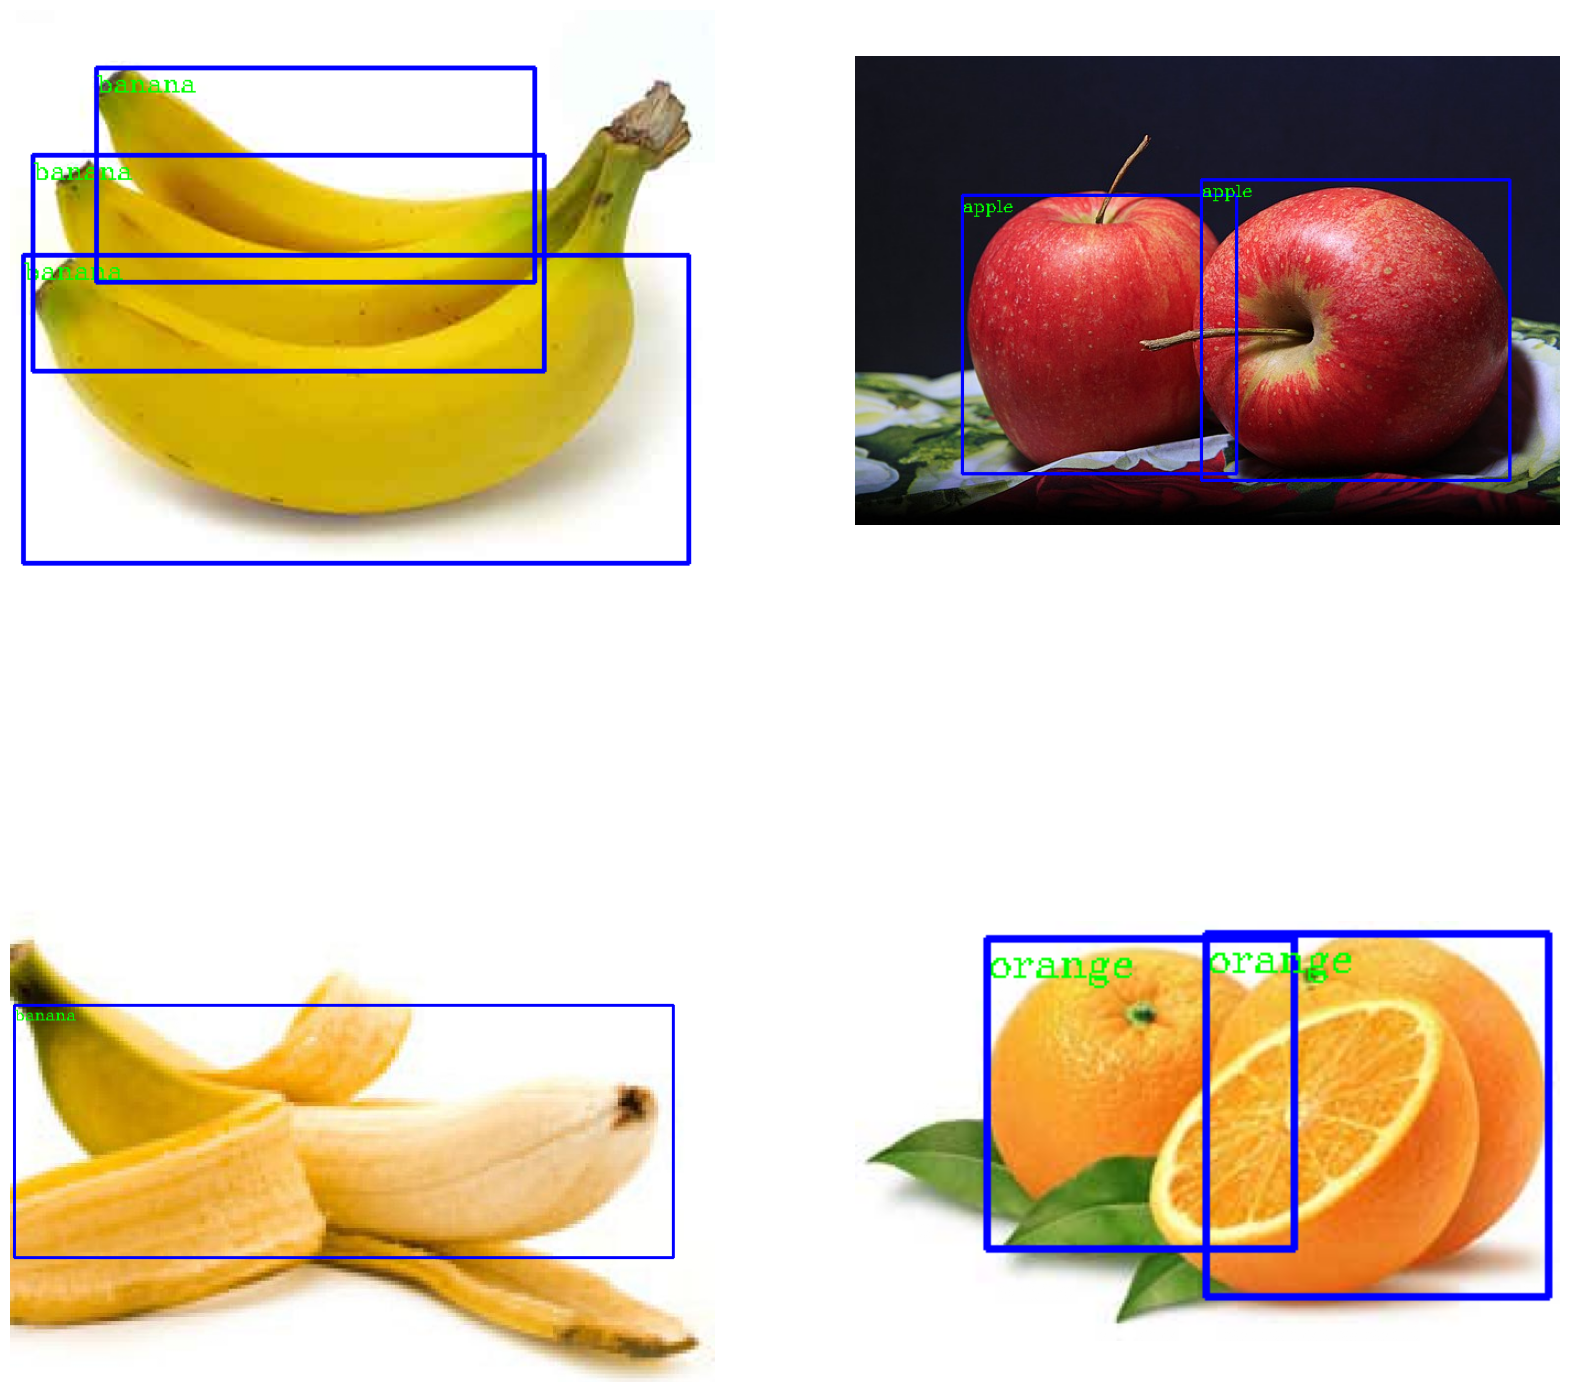

In [32]:
plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
    
    

# Download pretrained model

In [33]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/Users/oomprakash/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oomprakash/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
num_classes = 21  

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [35]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## **Download modules for model training**

In [36]:
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [37]:
# !git clone https://github.com/pytorch/vision.git
#!cd vision;cp references/detection/utils.py ../cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

In [38]:
# do this in anaconda prompt to get engine to work - takes a while to receive objects (took me about an hour)

#git clone https://github.com/pytorch/vision.git

In [39]:
from engine import train_one_epoch, evaluate
import utils

## **Train object detection model**

In [40]:
# let's train it for 2 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [ 0/50]  eta: 0:28:26  lr: 0.000107  loss: 3.5056 (3.5056)  loss_classifier: 3.2666 (3.2666)  loss_box_reg: 0.2182 (0.2182)  loss_objectness: 0.0036 (0.0036)  loss_rpn_box_reg: 0.0172 (0.0172)  time: 34.1242  data: 0.0893
Epoch: [0]  [10/50]  eta: 0:22:45  lr: 0.001126  loss: 2.9803 (2.9367)  loss_classifier: 2.7790 (2.6388)  loss_box_reg: 0.2579 (0.2853)  loss_objectness: 0.0021 (0.0027)  loss_rpn_box_reg: 0.0089 (0.0100)  time: 34.1495  data: 0.0498


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [20/50]  eta: 0:17:21  lr: 0.002146  loss: 1.5410 (1.9911)  loss_classifier: 1.2153 (1.6896)  loss_box_reg: 0.3101 (0.2902)  loss_objectness: 0.0021 (0.0025)  loss_rpn_box_reg: 0.0084 (0.0088)  time: 34.7535  data: 0.0530
Epoch: [0]  [30/50]  eta: 0:11:29  lr: 0.003165  loss: 0.5345 (1.5093)  loss_classifier: 0.3317 (1.2319)  loss_box_reg: 0.2052 (0.2644)  loss_objectness: 0.0026 (0.0044)  loss_rpn_box_reg: 0.0066 (0.0086)  time: 34.6644  data: 0.0631
Epoch: [0]  [40/50]  eta: 0:05:40  lr: 0.004184  loss: 0.5682 (1.3082)  loss_classifier: 0.2847 (1.0114)  loss_box_reg: 0.2868 (0.2840)  loss_objectness: 0.0022 (0.0042)  loss_rpn_box_reg: 0.0058 (0.0086)  time: 33.3573  data: 0.0548


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [0]  [49/50]  eta: 0:00:34  lr: 0.005000  loss: 0.6385 (1.1848)  loss_classifier: 0.2869 (0.8776)  loss_box_reg: 0.3252 (0.2942)  loss_objectness: 0.0014 (0.0044)  loss_rpn_box_reg: 0.0058 (0.0086)  time: 34.3454  data: 0.0431
Epoch: [0] Total time: 0:28:42 (34.4560 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Test:  [ 0/10]  eta: 0:08:09  model_time: 48.8435 (48.8435)  evaluator_time: 0.0068 (0.0068)  time: 48.9195  data: 0.0692


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.5286 (47.6569)  evaluator_time: 0.0059 (0.0070)  time: 47.6872  data: 0.0227
Test: Total time: 0:07:56 (47.6873 s / it)
Averaged stats: model_time: 48.5286 (47.6569)  evaluator_time: 0.0059 (0.0070)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [10/50]  eta: 0:21:58  lr: 0.005000  loss: 0.4171 (0.4891)  loss_classifier: 0.1541 (0.1709)  loss_box_reg: 0.2645 (0.3053)  loss_objectness: 0.0027 (0.0050)  loss_rpn_box_reg: 0.0068 (0.0078)  time: 32.9727  data: 0.0583


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [1]  [20/50]  eta: 0:16:47  lr: 0.005000  loss: 0.3240 (0.4148)  loss_classifier: 0.1091 (0.1397)  loss_box_reg: 0.2123 (0.2636)  loss_objectness: 0.0027 (0.0040)  loss_rpn_box_reg: 0.0059 (0.0074)  time: 33.7591  data: 0.0570
Epoch: [1]  [30/50]  eta: 0:11:11  lr: 0.005000  loss: 0.3195 (0.4089)  loss_classifier: 0.1045 (0.1307)  loss_box_reg: 0.2080 (0.2656)  loss_objectness: 0.0028 (0.0041)  loss_rpn_box_reg: 0.0076 (0.0085)  time: 33.9411  data: 0.0459
Epoch: [1]  [40/50]  eta: 0:05:35  lr: 0.005000  loss: 0.3498 (0.3970)  loss_classifier: 0.1084 (0.1243)  loss_box_reg: 0.2226 (0.2599)  loss_objectness: 0.0009 (0.0036)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 33.4683  data: 0.0651
Epoch: [1]  [49/50]  eta: 0:00:34  lr: 0.005000  loss: 0.3471 (0.3884)  loss_classifier: 0.1025 (0.1189)  loss_box_reg: 0.2165 (0.2575)  loss_objectness: 0.0005 (0.0033)  loss_rpn_box_reg: 0.0078 (0.0087)  time: 34.4288  data: 0.0636
Epoch: [1] Total time: 0:28:20 (34.0163 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:05  model_time: 48.4785 (48.4785)  evaluator_time: 0.0039 (0.0039)  time: 48.5508  data: 0.0684


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.3242 (47.4815)  evaluator_time: 0.0043 (0.0051)  time: 47.5096  data: 0.0224
Test: Total time: 0:07:55 (47.5097 s / it)
Averaged stats: model_time: 48.3242 (47.4815)  evaluator_time: 0.0043 (0.0051)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.409
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [10/50]  eta: 0:20:37  lr: 0.005000  loss: 0.3486 (0.3366)  loss_classifier: 0.0923 (0.0964)  loss_box_reg: 0.2460 (0.2291)  loss_objectness: 0.0013 (0.0026)  loss_rpn_box_reg: 0.0073 (0.0085)  time: 30.9281  data: 0.0336


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [2]  [20/50]  eta: 0:16:44  lr: 0.005000  loss: 0.2986 (0.3265)  loss_classifier: 0.0835 (0.0898)  loss_box_reg: 0.2164 (0.2274)  loss_objectness: 0.0007 (0.0017)  loss_rpn_box_reg: 0.0069 (0.0076)  time: 33.5263  data: 0.0397
Epoch: [2]  [30/50]  eta: 0:11:12  lr: 0.005000  loss: 0.2933 (0.3241)  loss_classifier: 0.0736 (0.0882)  loss_box_reg: 0.2097 (0.2263)  loss_objectness: 0.0006 (0.0017)  loss_rpn_box_reg: 0.0071 (0.0079)  time: 35.1235  data: 0.0432
Epoch: [2]  [40/50]  eta: 0:05:36  lr: 0.005000  loss: 0.2696 (0.3115)  loss_classifier: 0.0724 (0.0841)  loss_box_reg: 0.1837 (0.2168)  loss_objectness: 0.0017 (0.0019)  loss_rpn_box_reg: 0.0083 (0.0087)  time: 33.7430  data: 0.0597
Epoch: [2]  [49/50]  eta: 0:00:34  lr: 0.005000  loss: 0.1979 (0.2922)  loss_classifier: 0.0605 (0.0812)  loss_box_reg: 0.1445 (0.2004)  loss_objectness: 0.0016 (0.0022)  loss_rpn_box_reg: 0.0079 (0.0085)  time: 35.0590  data: 0.0652
Epoch: [2] Total time: 0:28:35 (34.3014 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:05  model_time: 48.4991 (48.4991)  evaluator_time: 0.0025 (0.0025)  time: 48.5700  data: 0.0683


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.2495 (47.4114)  evaluator_time: 0.0028 (0.0037)  time: 47.4379  data: 0.0223
Test: Total time: 0:07:54 (47.4380 s / it)
Averaged stats: model_time: 48.2495 (47.4114)  evaluator_time: 0.0028 (0.0037)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.826
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [20/50]  eta: 0:16:47  lr: 0.005000  loss: 0.2200 (0.2446)  loss_classifier: 0.0672 (0.0753)  loss_box_reg: 0.1459 (0.1603)  loss_objectness: 0.0006 (0.0025)  loss_rpn_box_reg: 0.0058 (0.0065)  time: 33.2682  data: 0.0480
Epoch: [3]  [30/50]  eta: 0:11:25  lr: 0.005000  loss: 0.2537 (0.2561)  loss_classifier: 0.0702 (0.0760)  loss_box_reg: 0.1699 (0.1706)  loss_objectness: 0.0018 (0.0028)  loss_rpn_box_reg: 0.0066 (0.0067)  time: 34.2876  data: 0.0438
Epoch: [3]  [40/50]  eta: 0:05:28  lr: 0.005000  loss: 0.2466 (0.2525)  loss_classifier: 0.0636 (0.0746)  loss_box_reg: 0.1699 (0.1682)  loss_objectness: 0.0019 (0.0027)  loss_rpn_box_reg: 0.0052 (0.0069)  time: 32.0248  data: 0.0441


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [3]  [49/50]  eta: 0:00:33  lr: 0.005000  loss: 0.2288 (0.2554)  loss_classifier: 0.0636 (0.0741)  loss_box_reg: 0.1667 (0.1712)  loss_objectness: 0.0019 (0.0026)  loss_rpn_box_reg: 0.0058 (0.0075)  time: 32.4723  data: 0.0508
Epoch: [3] Total time: 0:28:03 (33.6667 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:07  model_time: 48.6667 (48.6667)  evaluator_time: 0.0025 (0.0025)  time: 48.7379  data: 0.0687


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.3781 (47.5425)  evaluator_time: 0.0027 (0.0037)  time: 47.5691  data: 0.0223
Test: Total time: 0:07:55 (47.5692 s / it)
Averaged stats: model_time: 48.3781 (47.5425)  evaluator_time: 0.0027 (0.0037)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.848
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.588
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [10/50]  eta: 0:21:16  lr: 0.005000  loss: 0.2635 (0.2668)  loss_classifier: 0.0764 (0.0706)  loss_box_reg: 0.1720 (0.1886)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0057 (0.0059)  time: 31.9174  data: 0.0326
Epoch: [4]  [20/50]  eta: 0:16:21  lr: 0.005000  loss: 0.2275 (0.2520)  loss_classifier: 0.0669 (0.0742)  loss_box_reg: 0.1525 (0.1700)  loss_objectness: 0.0004 (0.0017)  loss_rpn_box_reg: 0.0056 (0.0062)  time: 31.9263  data: 0.0450


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [4]  [30/50]  eta: 0:11:07  lr: 0.005000  loss: 0.1721 (0.2348)  loss_classifier: 0.0522 (0.0667)  loss_box_reg: 0.1245 (0.1602)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0056 (0.0063)  time: 34.2064  data: 0.0677
Epoch: [4]  [40/50]  eta: 0:05:37  lr: 0.005000  loss: 0.1612 (0.2251)  loss_classifier: 0.0491 (0.0653)  loss_box_reg: 0.1039 (0.1516)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0058 (0.0067)  time: 34.8711  data: 0.0693
Epoch: [4]  [49/50]  eta: 0:00:33  lr: 0.005000  loss: 0.1858 (0.2268)  loss_classifier: 0.0525 (0.0666)  loss_box_reg: 0.1214 (0.1519)  loss_objectness: 0.0004 (0.0016)  loss_rpn_box_reg: 0.0050 (0.0067)  time: 34.7459  data: 0.0616
Epoch: [4] Total time: 0:28:17 (33.9436 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:07  model_time: 48.7008 (48.7008)  evaluator_time: 0.0022 (0.0022)  time: 48.7718  data: 0.0687


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.4162 (47.5749)  evaluator_time: 0.0023 (0.0032)  time: 47.6009  data: 0.0223
Test: Total time: 0:07:56 (47.6010 s / it)
Averaged stats: model_time: 48.4162 (47.5749)  evaluator_time: 0.0023 (0.0032)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.345
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [30/50]  eta: 0:11:19  lr: 0.000500  loss: 0.1690 (0.2053)  loss_classifier: 0.0566 (0.0618)  loss_box_reg: 0.1032 (0.1338)  loss_objectness: 0.0004 (0.0027)  loss_rpn_box_reg: 0.0051 (0.0070)  time: 33.8895  data: 0.0405


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [5]  [40/50]  eta: 0:05:32  lr: 0.000500  loss: 0.1690 (0.2014)  loss_classifier: 0.0583 (0.0617)  loss_box_reg: 0.1032 (0.1309)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0048 (0.0064)  time: 32.9164  data: 0.0439
Epoch: [5]  [49/50]  eta: 0:00:33  lr: 0.000500  loss: 0.1753 (0.2036)  loss_classifier: 0.0580 (0.0626)  loss_box_reg: 0.1153 (0.1322)  loss_objectness: 0.0010 (0.0024)  loss_rpn_box_reg: 0.0048 (0.0063)  time: 32.5295  data: 0.0484
Epoch: [5] Total time: 0:28:01 (33.6210 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:07  model_time: 48.6973 (48.6974)  evaluator_time: 0.0021 (0.0021)  time: 48.7729  data: 0.0734


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.3956 (47.5851)  evaluator_time: 0.0023 (0.0033)  time: 47.6120  data: 0.0229
Test: Total time: 0:07:56 (47.6121 s / it)
Averaged stats: model_time: 48.3956 (47.5851)  evaluator_time: 0.0023 (0.0033)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.558
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [30/50]  eta: 0:11:02  lr: 0.000500  loss: 0.1583 (0.1835)  loss_classifier: 0.0533 (0.0580)  loss_box_reg: 0.0953 (0.1174)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0052 (0.0064)  time: 34.0345  data: 0.0466


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [6]  [40/50]  eta: 0:05:35  lr: 0.000500  loss: 0.1860 (0.1900)  loss_classifier: 0.0533 (0.0598)  loss_box_reg: 0.1164 (0.1219)  loss_objectness: 0.0010 (0.0019)  loss_rpn_box_reg: 0.0058 (0.0064)  time: 34.1414  data: 0.0461
Epoch: [6]  [49/50]  eta: 0:00:34  lr: 0.000500  loss: 0.1860 (0.1942)  loss_classifier: 0.0634 (0.0612)  loss_box_reg: 0.1216 (0.1250)  loss_objectness: 0.0009 (0.0017)  loss_rpn_box_reg: 0.0049 (0.0063)  time: 35.5637  data: 0.0477
Epoch: [6] Total time: 0:28:20 (34.0114 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:05  model_time: 48.4876 (48.4876)  evaluator_time: 0.0024 (0.0024)  time: 48.5636  data: 0.0736


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.2219 (47.3876)  evaluator_time: 0.0024 (0.0033)  time: 47.4143  data: 0.0228
Test: Total time: 0:07:54 (47.4144 s / it)
Averaged stats: model_time: 48.2219 (47.3876)  evaluator_time: 0.0024 (0.0033)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.885
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.564
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [40/50]  eta: 0:05:53  lr: 0.000500  loss: 0.1847 (0.1981)  loss_classifier: 0.0561 (0.0614)  loss_box_reg: 0.1226 (0.1284)  loss_objectness: 0.0008 (0.0020)  loss_rpn_box_reg: 0.0064 (0.0063)  time: 36.2285  data: 0.0537


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [7]  [49/50]  eta: 0:00:34  lr: 0.000500  loss: 0.1581 (0.1911)  loss_classifier: 0.0493 (0.0595)  loss_box_reg: 0.0959 (0.1236)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0042 (0.0062)  time: 34.6975  data: 0.0458
Epoch: [7] Total time: 0:28:57 (34.7575 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:07  model_time: 48.7270 (48.7270)  evaluator_time: 0.0022 (0.0022)  time: 48.7977  data: 0.0684


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.3923 (47.5293)  evaluator_time: 0.0023 (0.0032)  time: 47.5555  data: 0.0223
Test: Total time: 0:07:55 (47.5556 s / it)
Averaged stats: model_time: 48.3923 (47.5293)  evaluator_time: 0.0023 (0.0032)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [20/50]  eta: 0:17:13  lr: 0.000500  loss: 0.2029 (0.1908)  loss_classifier: 0.0622 (0.0593)  loss_box_reg: 0.1294 (0.1231)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0056 (0.0061)  time: 34.3863  data: 0.0456


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [8]  [30/50]  eta: 0:11:23  lr: 0.000500  loss: 0.1845 (0.1944)  loss_classifier: 0.0586 (0.0608)  loss_box_reg: 0.1173 (0.1256)  loss_objectness: 0.0004 (0.0022)  loss_rpn_box_reg: 0.0036 (0.0059)  time: 34.2710  data: 0.0464
Epoch: [8]  [40/50]  eta: 0:05:43  lr: 0.000500  loss: 0.1845 (0.1905)  loss_classifier: 0.0585 (0.0604)  loss_box_reg: 0.1173 (0.1222)  loss_objectness: 0.0004 (0.0020)  loss_rpn_box_reg: 0.0042 (0.0059)  time: 34.2224  data: 0.0534
Epoch: [8]  [49/50]  eta: 0:00:34  lr: 0.000500  loss: 0.1742 (0.1924)  loss_classifier: 0.0518 (0.0608)  loss_box_reg: 0.1140 (0.1234)  loss_objectness: 0.0004 (0.0019)  loss_rpn_box_reg: 0.0046 (0.0063)  time: 34.3663  data: 0.0632
Epoch: [8] Total time: 0:28:36 (34.3254 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:06  model_time: 48.5984 (48.5984)  evaluator_time: 0.0022 (0.0022)  time: 48.6692  data: 0.0687


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.2708 (47.4141)  evaluator_time: 0.0024 (0.0032)  time: 47.4403  data: 0.0224
Test: Total time: 0:07:54 (47.4404 s / it)
Averaged stats: model_time: 48.2708 (47.4141)  evaluator_time: 0.0024 (0.0032)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.890
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.569
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [10/50]  eta: 0:23:26  lr: 0.000500  loss: 0.2437 (0.2374)  loss_classifier: 0.0768 (0.0712)  loss_box_reg: 0.1512 (0.1562)  loss_objectness: 0.0016 (0.0025)  loss_rpn_box_reg: 0.0062 (0.0075)  time: 35.1550  data: 0.0598


libpng warning: iCCP: known incorrect sRGB profile


Epoch: [9]  [20/50]  eta: 0:17:00  lr: 0.000500  loss: 0.2177 (0.2189)  loss_classifier: 0.0648 (0.0665)  loss_box_reg: 0.1455 (0.1426)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0061 (0.0081)  time: 33.4263  data: 0.0507
Epoch: [9]  [30/50]  eta: 0:11:29  lr: 0.000500  loss: 0.1584 (0.1896)  loss_classifier: 0.0468 (0.0584)  loss_box_reg: 0.1021 (0.1227)  loss_objectness: 0.0007 (0.0015)  loss_rpn_box_reg: 0.0042 (0.0070)  time: 34.1279  data: 0.0464
Epoch: [9]  [40/50]  eta: 0:05:43  lr: 0.000500  loss: 0.1295 (0.1949)  loss_classifier: 0.0432 (0.0599)  loss_box_reg: 0.0840 (0.1270)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0031 (0.0065)  time: 34.6802  data: 0.0463
Epoch: [9]  [49/50]  eta: 0:00:33  lr: 0.000500  loss: 0.1584 (0.1901)  loss_classifier: 0.0532 (0.0592)  loss_box_reg: 0.0996 (0.1233)  loss_objectness: 0.0008 (0.0016)  loss_rpn_box_reg: 0.0038 (0.0060)  time: 32.5488  data: 0.0388
Epoch: [9] Total time: 0:28:18 (33.9742 s / it)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


creating index...
index created!
Test:  [ 0/10]  eta: 0:08:08  model_time: 48.7638 (48.7638)  evaluator_time: 0.0023 (0.0023)  time: 48.8344  data: 0.0682


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Test:  [ 9/10]  eta: 0:00:47  model_time: 48.3450 (47.5496)  evaluator_time: 0.0023 (0.0032)  time: 47.5757  data: 0.0224
Test: Total time: 0:07:55 (47.5758 s / it)
Averaged stats: model_time: 48.3450 (47.5496)  evaluator_time: 0.0023 (0.0032)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

In [41]:
torch.save(model.state_dict(), 'faster_rcnn_state.pth')

# **Test model**

In [43]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "./faster_rcnn_state.pth"

num_classes = 21

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [60]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    
    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.70
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

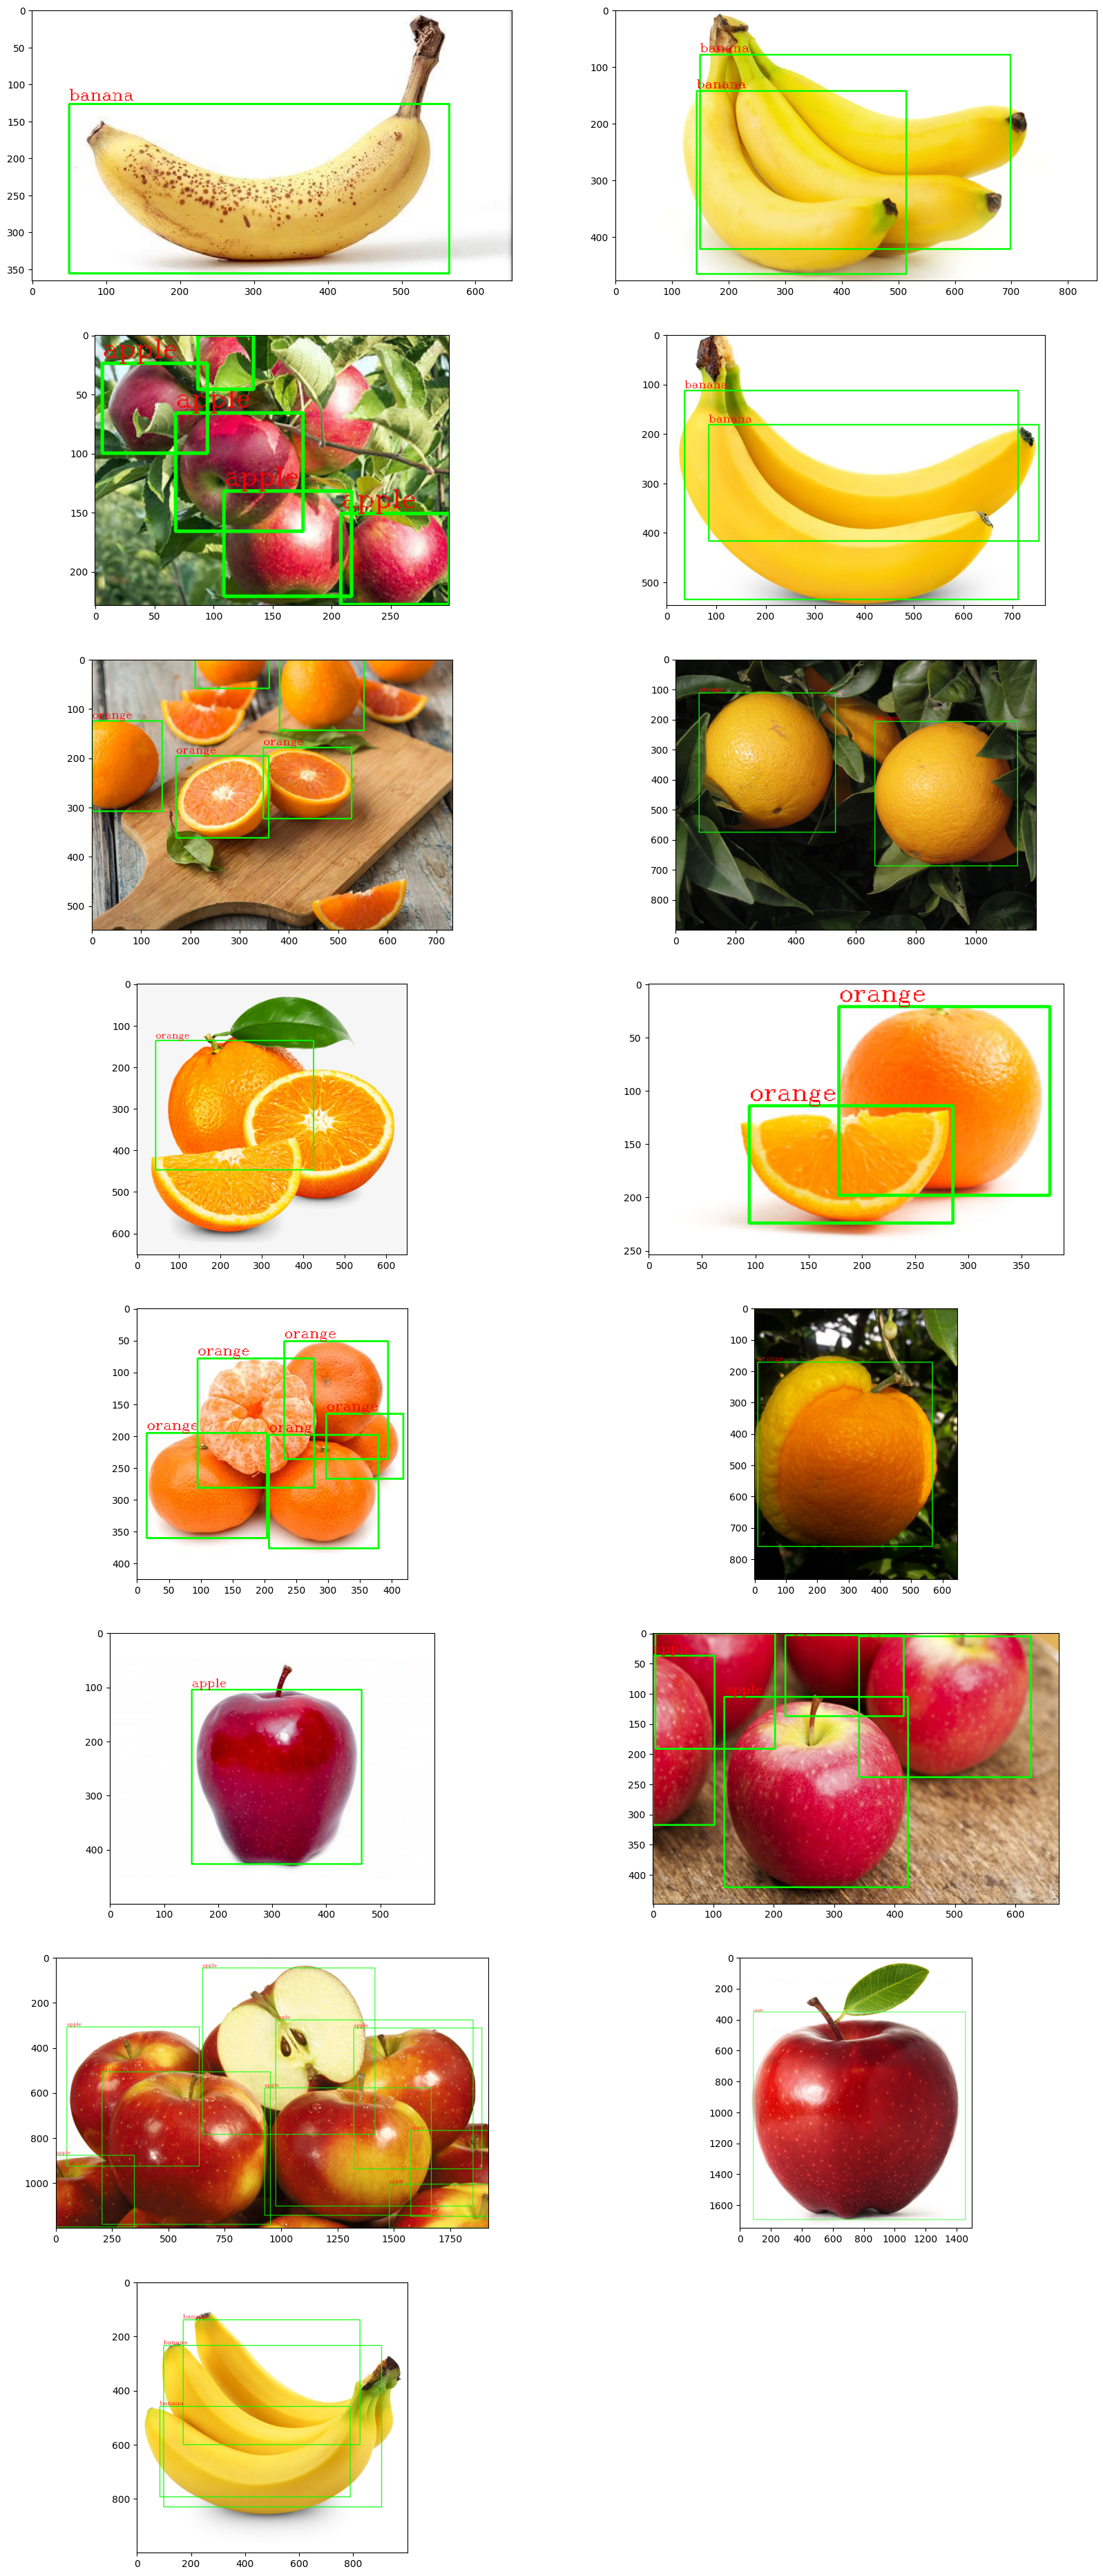

In [64]:
pred_path = (r"/Users/oomprakash/Desktop/python/test")
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]
plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
    plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result